## Minimizer template

This notebook contains the basic syntax required to run a minimization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace_manager.data import data_MPGADGET
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace_manager.likelihood import likelihood
from lace_manager.sampler import emcee_sampler
from lace_manager.sampler import iminuit_minimizer

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
z_max=4.5
emu_type="polyfit"
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,sim_label=test_sim_label,
                                zmax=z_max,polyfit=(emu_type=="polyfit"))

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00


### Emulator and training set

Create a set of training data to train an emulator

In [4]:
# Set up emulator training set
archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,z_max=z_max,
                            drop_tau_rescalings=True,drop_temp_rescalings=True,)

In [5]:
use_nyx=False
if use_nyx:
    from lace.emulator import p1d_archive_Nyx
    archive=p1d_archive_Nyx.archiveP1D_Nyx(fname=None,verbose=False)

In [6]:
# turn this on to check if we go outside the convex hull
check_hull=False

In [7]:
## Build emulator
if use_nyx:
    paramList=['mF', 'sigT_Mpc', 'gamma', 'Delta2_p', 'n_p']
    kmax_Mpc=2
else:
    paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
    kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type=emu_type,passarchive=archive,
                                kmax_Mpc=kmax_Mpc,
                                check_hull=check_hull)

 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.25 seconds


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [8]:
if False:
    free_param_limits=[[1.1e-09, 3.19e-09], [0.89, 1.05],
                   [-0.2, 0.2],[-0.2, 0.2],[-0.2, 0.2],[-0.2, 0.2],
                   [-0.2, 0.2],[-0.2, 0.2],[-0.2, 0.2],[-0.2, 0.2]]
    free_param_names=["As","ns","ln_tau_0","ln_tau_1","ln_sigT_kms_0","ln_sigT_kms_1",
                  "ln_gamma_0","ln_gamma_1","ln_kF_0","ln_kF_1"]
else:
    free_param_limits=[[1.1e-09, 3.19e-09], [0.89, 1.05],[-0.2, 0.2]]
    free_param_names=["As","ns","ln_tau_0"]    
prior=None

In [9]:
# set this to zero to ignore emulator covariance (1 by default)
emu_cov_factor=0

In [10]:
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_param_names=free_param_names,
                            free_param_limits=free_param_limits,
                            prior_Gauss_rms=prior,
                            include_CMB=False,
                            emu_cov_factor=emu_cov_factor)

# Try scipy minimizer

In [11]:
results=like.maximise_posterior()

In [12]:
best_fit=results.x
print(best_fit)

[0.4386349  0.47793354 0.50246939]


In [13]:
best_fit_params=like.parameters_from_sampling_point(best_fit)
print('best fit parameters')
for p in best_fit_params:
    print(p.info_str())

best fit parameters
As = 2.0167469420885187e-09
ns = 0.96646936577858
ln_tau_0 = 0.0009877555006148064


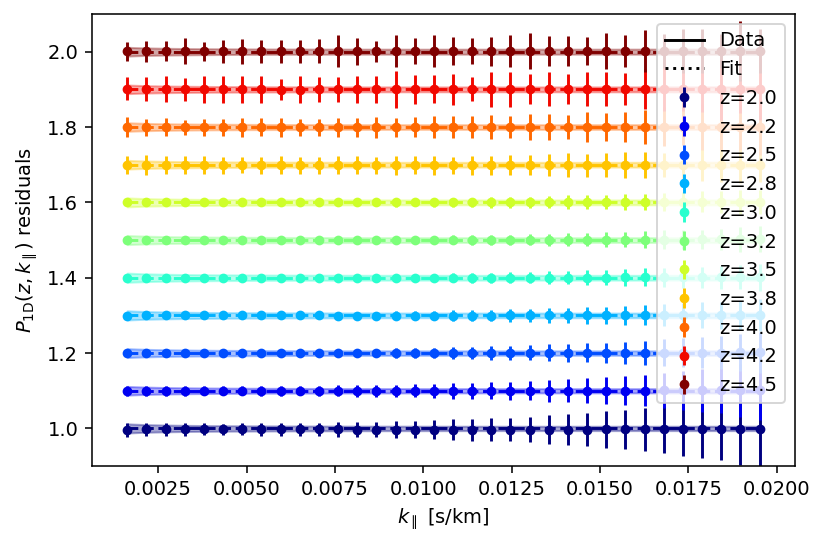

In [14]:
like.plot_p1d(values=best_fit,residuals=True)

# Try iminuit minimizer

In [15]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [16]:
minimizer.minimize(compute_hesse=True)

will run migrad
will compute Hessian matrix


best-fit values = [0.43866795 0.47802673 0.50243634]


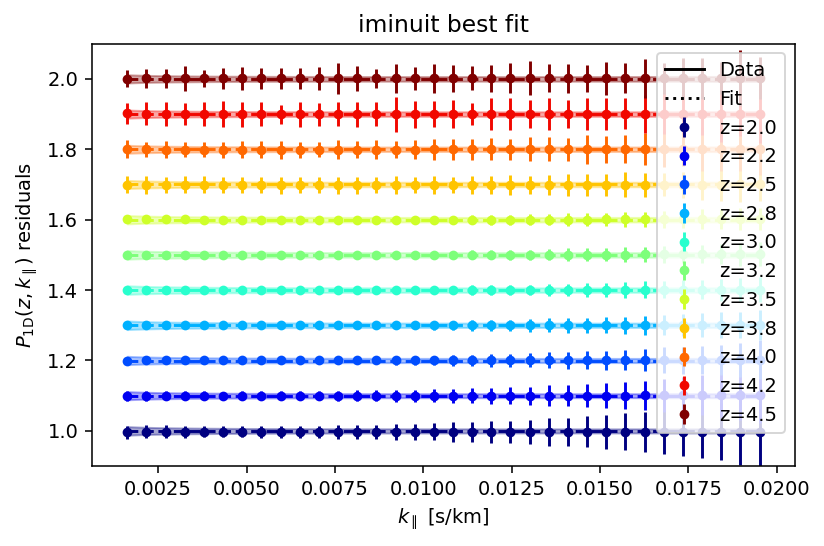

In [17]:
minimizer.plot_best_fit()

compute true values for As ns


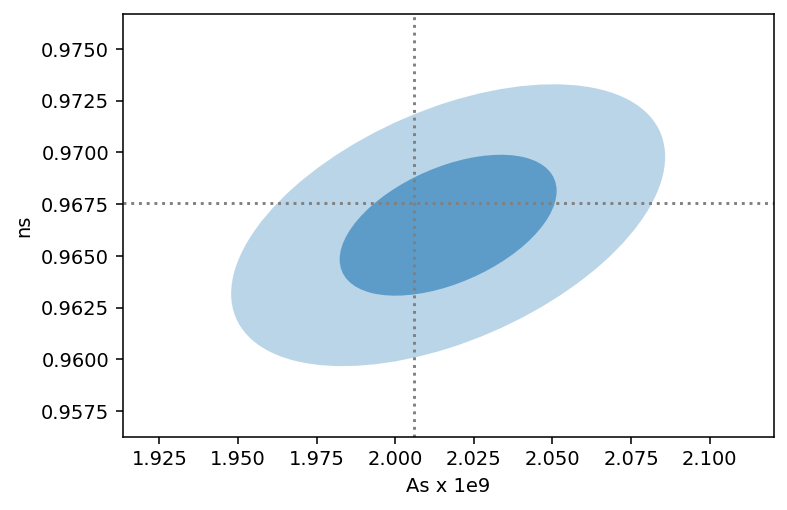

In [18]:
minimizer.plot_ellipses('As','ns')

### Access the actual minimizer object from iminuit

In [19]:
if False:
    minimizer.minimizer.migrad()
    minimizer.minimizer.draw_mncontour("x0", "x1")
    minimizer.minimizer.draw_mnprofile("x0")